In [1]:
import os
from dotenv import load_dotenv

# Tải biến môi trường từ tệp .env
load_dotenv()

# Lấy khóa API từ biến môi trường
google_api_key = os.getenv("GOOGLE_API_KEY")
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")

In [2]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

In [3]:
os.environ['OPENAI_API_KEY'] = google_api_key

In [10]:
from langchain_community.document_loaders import WebBaseLoader
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain import hub
from langchain_google_genai import ChatGoogleGenerativeAI

In [5]:
# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [6]:
splits

[Document(page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n

In [8]:
# Embed
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=embeddings)

retriever = vectorstore.as_retriever()

c:\Users\Admin\Documents\GPT_LLM\LLMVenv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
c:\Users\Admin\Documents\GPT_LLM\LLMVenv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Admin\Documents\GPT_LLM\LLMVenv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If yo

In [12]:
#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=google_api_key, temperature=0)
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("What is Task Decomposition?")

'Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. This can be done using simple prompting, task-specific instructions, or human inputs. Task decomposition helps LLMs plan ahead and utilize more test-time computation to enhance model performance on complex tasks.'

## Indexing

In [14]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

In [15]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

8

In [16]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [19]:
embd = GoogleGenerativeAIEmbeddings(model='models/text-embedding-004')
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
len(query_result)
query_result

[-0.06151065602898598,
 0.016142399981617928,
 0.004602184519171715,
 -0.026363614946603775,
 0.011735357344150543,
 0.07476455718278885,
 0.0218959990888834,
 -0.003995611798018217,
 -0.02363644540309906,
 0.053892605006694794,
 -0.023270966485142708,
 0.02251134067773819,
 0.08222145587205887,
 -0.014574114233255386,
 0.003847495187073946,
 -0.05266005918383598,
 0.0015212490689009428,
 0.06380945444107056,
 -0.010724115185439587,
 0.030634600669145584,
 0.022040270268917084,
 -0.023588964715600014,
 0.0006107819499447942,
 -0.0021678197663277388,
 0.00830293819308281,
 -0.059129517525434494,
 0.01104989554733038,
 -0.04603550583124161,
 0.04262206703424454,
 -0.06444154679775238,
 0.0007407244411297143,
 0.06855612248182297,
 0.042161256074905396,
 -0.029287412762641907,
 0.04808570072054863,
 0.027017883956432343,
 0.031078366562724113,
 0.0156487375497818,
 0.07937292009592056,
 -0.026655126363039017,
 -0.011133858002722263,
 -0.05330640822649002,
 0.02429596707224846,
 0.00010556

In [18]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.6699860150348195


In [20]:
docs

[Document(page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final re

In [21]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(docs)

In [22]:
splits

[Document(page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n

- vectorstore.as_retriever(): Hàm này chuyển đổi vectorstore thành một retriever.
- Retriever là một thành phần giúp tìm kiếm và truy vấn các tài liệu trong cơ sở dữ liệu vector dựa trên các embeddings.

In [25]:
# Index
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=embeddings)

retriever = vectorstore.as_retriever()

## Retrieval

In [26]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [27]:
docs_retri = retriever.get_relevant_documents("What is Task Decomposition?")
len(docs_retri)

c:\Users\Admin\Documents\GPT_LLM\LLMVenv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


1

## Generation

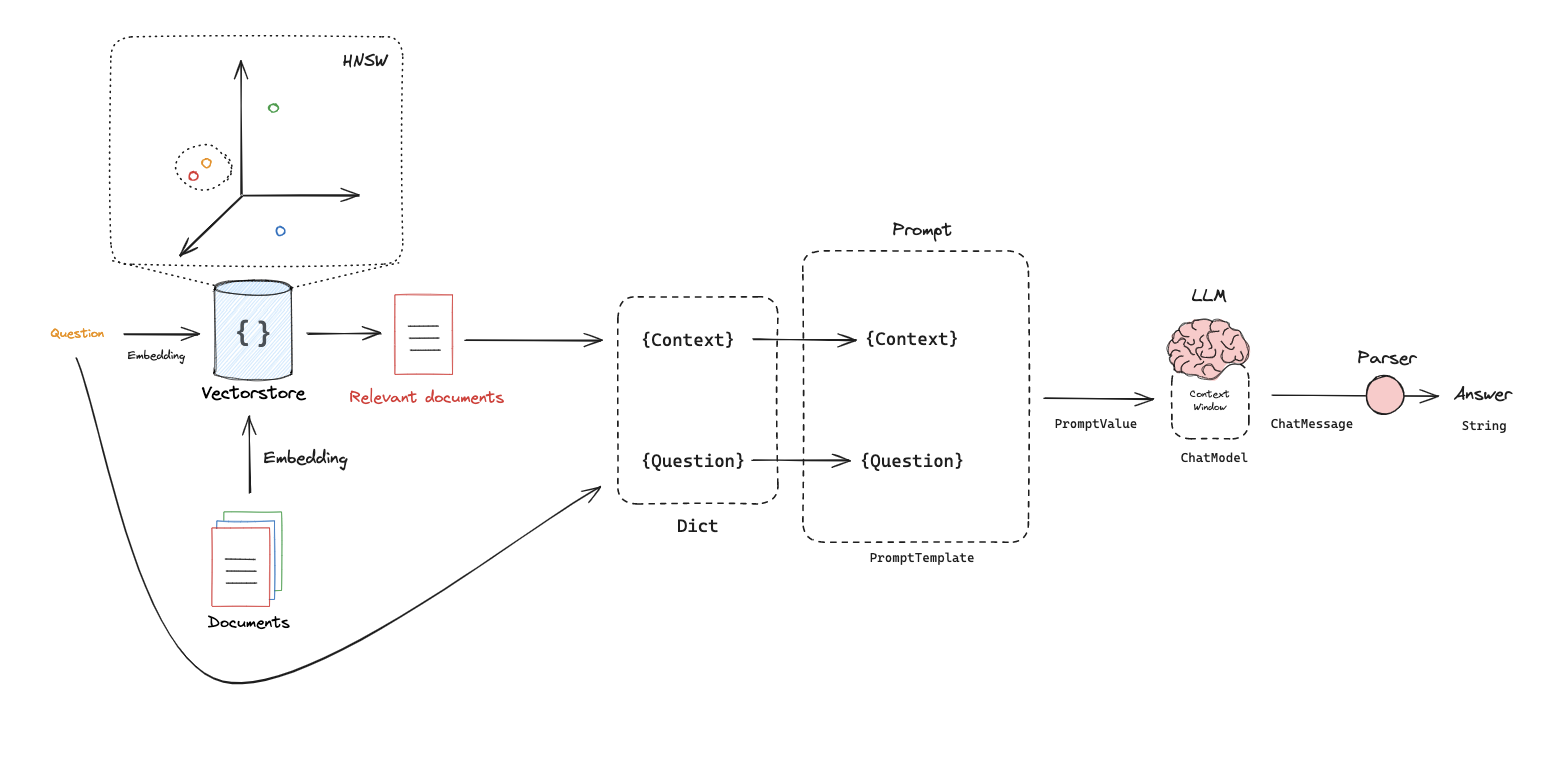

In [28]:
from langchain.prompts import ChatPromptTemplate

In [29]:
# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'))])